In [1]:
from PIL import Image
from BileDuct_dataset_v4 import BileDuctDataset
import torchvision.transforms as transforms

In [2]:
train_set = BileDuctDataset(split='train', 
                            sample_slices=1,)

load train data from h5 file...


/data1/zfx/code/sGAN/BileDuct_dataset_v4.py:335: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return f['image'][:], f['label'][:], f['datasize'].value, f.attrs['patient_id_list'], eval(f.attrs['index2pid_dict']), eval(f.attrs['index2slice_dict'])


In [3]:
batch = train_set.__getitem__(100)

In [4]:
batch['image'].shape

torch.Size([1, 256, 256])

In [5]:
batch['label'].shape

torch.Size([256, 256])

In [1]:
import numpy as np

In [2]:
z_sample = np.random.normal(0, 1, size=[24, 400]).astype(np.float32)

In [5]:
import torch

In [6]:
torch.randn([24, 400]).shape

torch.Size([24, 400])

In [1]:
path = '/data1/zfx/code/sGAN/saved/epoch_299/fake_samples_000.png'

图像大小: (2066, 776)
图像类型: RGB


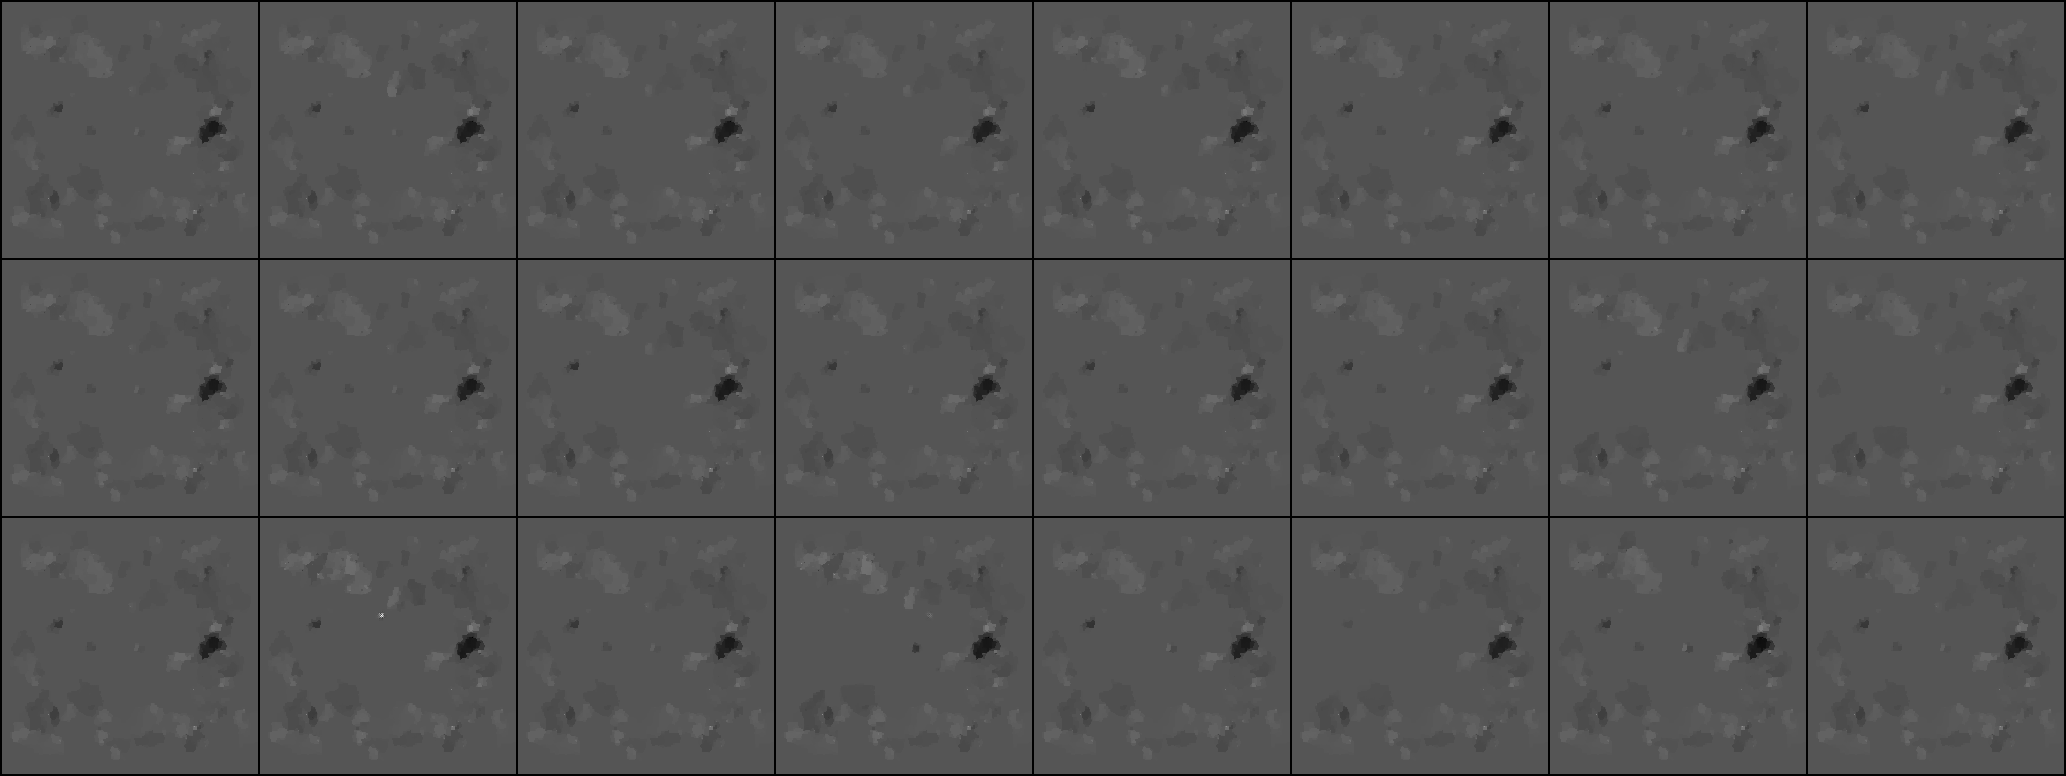

In [2]:
from PIL import Image
from IPython.display import display

# 打开PNG图像
image = Image.open(path)

# 显示图像大小和类型
print('图像大小:', image.size)
print('图像类型:', image.mode)

# 在Jupyter Notebook中展示图像
display(image)


In [1]:
model_path = '/data1/zfx/code/sGAN/saved/epoch_366/netG_epoch_366.pth'

In [2]:
from BileDuct_dataset_v4 import BileDuctDataset
from gan import Discriminator,Generator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '7'

In [3]:
train_set = BileDuctDataset(split='train', sample_slices=1)

load train data from h5 file...


/data1/zfx/code/sGAN/BileDuct_dataset_v4.py:335: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  return f['image'][:], f['label'][:], f['datasize'].value, f.attrs['patient_id_list'], eval(f.attrs['index2pid_dict']), eval(f.attrs['index2slice_dict'])


In [4]:
data = train_set.__getitem__(100)

In [5]:
image = data['image']
label = data['label']

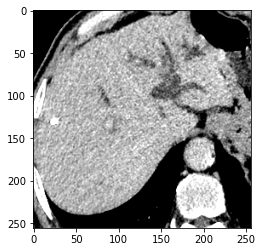

In [6]:
plt.imshow(image[0], cmap='gray')

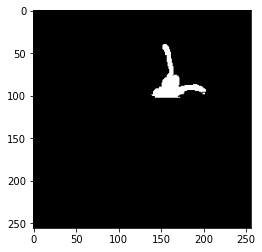

In [7]:
plt.imshow(label, cmap='gray')

In [8]:
netG=Generator()
netG.load_state_dict(torch.load(model_path, map_location='cuda'))

<All keys matched successfully>

In [9]:
image = image.unsqueeze(0)
label = label.unsqueeze(0)

In [10]:
real_label_onehot = torch.nn.functional.one_hot(label.long(), num_classes=2).permute(0, 3, 1, 2).float()  # 转换为one-hot编码

In [11]:
real_label_onehot.shape

torch.Size([1, 2, 256, 256])

In [13]:
netG.to('cuda')

Generator(
  (layer0): Sequential(
    (0): Conv2d(2, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (layer1): Block(
    (relu): ReLU()
    (encoder): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer2): Block(
    (relu): ReLU()
    (encoder): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer3): Block(
    (relu): ReLU()
    (encoder): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (layer4): Block(
    (relu): ReLU()
    (encoder): Sequential(
      (0): Conv2d(512, 512, kernel_size=(4, 4)

In [14]:
z = torch.randn([1, 400]).cuda()
res = netG(real_label_onehot.cuda(), z)

In [16]:
res.shape

torch.Size([1, 1, 256, 256])

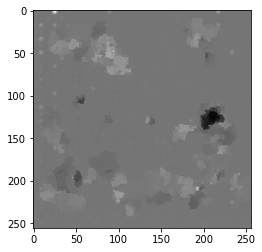

In [18]:
plt.imshow(res.detach().cpu().numpy()[0][0], cmap='gray')

In [2]:
import torch

In [3]:
input = torch.rand([8,256,256])
label = torch.rand([8,256,256])
input[input > 0.5] = 1
input[input <=0.5] = 0

label[label > 0.5] = 1
label[label <=0.5] = 0

In [4]:
input_onehot = torch.nn.functional.one_hot(input.long(), num_classes=2).permute(0, 3, 1, 2).float()  # 转换为one-hot编码
label_onthot = torch.nn.functional.one_hot(label.long(), num_classes=2).permute(0, 3, 1, 2).float()  # 转换为one-hot编码

In [5]:
def get_class_balancing(input, label):
    
    class_occurence = torch.sum(label, dim=(0, 2, 3))
        
    class_occurence[0] = 0
    num_of_classes = (class_occurence > 0).sum()
    coefficients = torch.reciprocal(class_occurence) * torch.numel(label) / (num_of_classes * label.shape[1])
    integers = torch.argmax(label, dim=1, keepdim=True)
        
    coefficients[0] = 0
    weight_map = coefficients[integers]

    return weight_map


In [6]:
weight = get_class_balancing(None, label_onthot)

In [7]:
weight.shape

torch.Size([8, 1, 256, 256])

In [8]:
weight

tensor([[[[1.9988, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.9988, 0.0000],
          [1.9988, 1.9988, 1.9988,  ..., 1.9988, 1.9988, 1.9988],
          ...,
          [0.0000, 1.9988, 0.0000,  ..., 0.0000, 1.9988, 0.0000],
          [1.9988, 1.9988, 0.0000,  ..., 1.9988, 1.9988, 0.0000],
          [1.9988, 1.9988, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.9988, 1.9988],
          [0.0000, 0.0000, 1.9988,  ..., 0.0000, 0.0000, 1.9988],
          [0.0000, 1.9988, 0.0000,  ..., 1.9988, 0.0000, 0.0000],
          ...,
          [1.9988, 1.9988, 1.9988,  ..., 1.9988, 1.9988, 0.0000],
          [0.0000, 1.9988, 0.0000,  ..., 1.9988, 1.9988, 1.9988],
          [1.9988, 0.0000, 0.0000,  ..., 1.9988, 0.0000, 0.0000]]],


        [[[1.9988, 1.9988, 0.0000,  ..., 1.9988, 0.0000, 1.9988],
          [1.9988, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.9988],
          [0.0000, 0.0000, 0.0000,  ..

In [9]:
label_onthot

tensor([[[[0., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 0., 1.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [1., 0., 1.,  ..., 1., 0., 1.],
          [0., 0., 1.,  ..., 0., 0., 1.],
          [0., 0., 1.,  ..., 1., 1., 1.]],

         [[1., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 1., 0.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [0., 1., 0.,  ..., 0., 1., 0.],
          [1., 1., 0.,  ..., 1., 1., 0.],
          [1., 1., 0.,  ..., 0., 0., 0.]]],


        [[[1., 1., 1.,  ..., 1., 0., 0.],
          [1., 1., 0.,  ..., 1., 1., 0.],
          [1., 0., 1.,  ..., 0., 1., 1.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 1.],
          [1., 0., 1.,  ..., 0., 0., 0.],
          [0., 1., 1.,  ..., 0., 1., 1.]],

         [[0., 0., 0.,  ..., 0., 1., 1.],
          [0., 0., 1.,  ..., 0., 0., 1.],
          [0., 1., 0.,  ..., 1., 0., 0.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 0.],
        

In [21]:
from BileDuct_dataset_v4 import BileDuctDataset
import torch

In [5]:
dataset = BileDuctDataset(split='train')

load train data from h5 file...


In [6]:
dataset.__len__()

1436

In [7]:
from torchvision import transforms as TR

In [10]:
sample = dataset.__getitem__(10)

In [47]:
image = sample['image']

In [49]:
TR.functional.normalize(image[1].unsqueeze(0), (0.5,), (0.5,))

tensor([[[-5.9174, -5.9174, -5.9174,  ...,  0.5569,  2.2060,  3.1222],
         [-5.9174, -5.9174, -5.9174,  ...,  0.6791,  2.2060,  2.7557],
         [-5.9174, -5.9174, -5.9174,  ..., -0.9700,  1.2899,  1.6563],
         ...,
         [-1.0922, -3.2299, -5.9174,  ..., -5.9174, -5.9174, -5.9174],
         [ 0.1904, -2.4359, -5.9174,  ..., -5.9174, -5.9174, -5.9174],
         [ 0.9845, -1.3976, -5.1234,  ..., -5.9174, -5.9174, -5.9174]]])